In [1]:
# Imports
import numpy as np
import pandas as pd
import math
import random
from random import randint
import matplotlib.pyplot as plt
import time
import heapq
import networkx as nx

In [2]:
# function that creates the graphs g1 and g2, where g1 is the adjacency matrix representation and g2 is the adjacency list representation
def make_graph(NUMBER_NODES, NUMBER_EDGES):
    if NUMBER_NODES*(NUMBER_NODES-1)<NUMBER_EDGES: #max number of edges in directed graph is v(v-1)
        print("Impossible to generate a simple graph with %i nodes and %i edges!\n" %(NUMBER_NODES,NUMBER_EDGES))
        return None

    # create g2, the adjacency list representation
    g2 = [[] for node in range(NUMBER_NODES)]
    existing_edges = set() #use set to check since it is O(1) on average
#create simple cycle to guarantee strong connectivity
    for i in range(NUMBER_NODES):
        u = i
        v = (i + 1) % NUMBER_NODES  # wrap around to form a cycle
        w = randint(1, 20)
        g2[u].append([v, w]) #add to adjacency list
        existing_edges.add((u, v))
    
    remaining_edges = NUMBER_EDGES - NUMBER_NODES

    while remaining_edges>0: 
        start_node = randint(0,NUMBER_NODES-1) #select a random start node from the nodes
        end_node = randint(0,NUMBER_NODES-1) #select a random end node from the nodes
        weight = randint(1,20) # give it a random weight from 1 to 20
        
        if start_node != end_node and (start_node, end_node) not in existing_edges:
            g2[start_node].append([end_node, weight])
            existing_edges.add((start_node, end_node))
            remaining_edges -= 1
                

    # create g1, the adjacency matrix representation from g2
    g1 = np.array([[0 for i in range(NUMBER_NODES)] for i in range(NUMBER_NODES)])
    for i in range(len(g2)):
        for j in range(len(g2[i])):
            node = g2[i][j][0]
            weight = g2[i][j][1]
            g1[i][node] = weight  
    return g1, g2
 

# function that prints the graph and plots it
def print_graph(g1, g2):
    print("Adjacency Matrix:")
    print(g1)
    
    print("Adjacency List:")
    for i in range(len(g2)):
        print("from node %02i: " %(i),end="")
        print(g2[i])

    # plot the graph visually
    G = nx.DiGraph() #nx.DiGraph for directed graph
    for i in range(len(g2)): G.add_node(i)
    for i in range(len(g2)):
        for j in range(len(g2[i])): G.add_edge(i,g2[i][j][0],weight=g2[i][j][1])
    try: 
        pos = nx.planar_layout(G)
        nx.draw(G,pos, with_labels=True)
    except nx.NetworkXException:
        print("\nGraph is not planar, using alternative representation")
        pos = nx.spring_layout(G)
        nx.draw(G,pos, with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [3]:
#Implementation of Priority Queue using an array

class PriorityQueueArray(object):
    def __init__(self):
        self.queue = []

    def __str__(self):
        return ' '.join([str(i) for i in self.queue])

    # for checking if the queue is empty
    def isEmpty(self):
        return len(self.queue) == 0

    def length(self):
        return len(self.queue) 

    # for inserting an element in the queue
    def insert(self, data):
        self.queue.append(data)

    # for popping an element based on Priority
    def pop(self):
        try:
            min = -1
            for i in range(len(self.queue)):
                if self.queue[i][0] < self.queue[min][0]: # O(|V|)
                    min = i
            item = self.queue[min]
            del self.queue[min]
            return item
        except IndexError:
            print()
            exit()
   
       
    def remove(self, x):
        for i in range(len(self.queue)):
                if self.queue[i][1] == x:
                    del self.queue[i]
                    break

In [4]:
# function that implements the Dijkstra's algorithm for single-pair shortest paths using adjacency matrix and array priority queue
def dijkstra_adj_matrix_array(g, source):
    d = [math.inf for i in range(len(g))]
    S = [0 for i in range(len(g))]
    pi = [-1 for x in range(len(g))]

    d[source] = 0

    pq = PriorityQueueArray()
    for v in range(len(g)):
        pq.insert([d[v], v]) # Initializing: O(|V|)
    
    while not pq.isEmpty(): 
        u = pq.pop()
        
        S[u[1]] = 1 #add node that is pop to visited

        # check all vertices adjacent to u: O(1)
        # Loop through all the neighbours: V*V Times, since its a matrix. O(|V*V|)

        for v in range(len(g[u[1],:])): #v is neighbouring node to u
            if g[u[1]][v]!=0:
                if (S[v]!=1 and d[v]>d[u[1]]+g[u[1]][v]):
                    pq.remove(v)
                    d[v] = d[u[1]]+g[u[1]][v] #update estimated distance
                    pi[v] = u[1] #update predecessor
                    pq.insert([d[v], v]) 
    return d

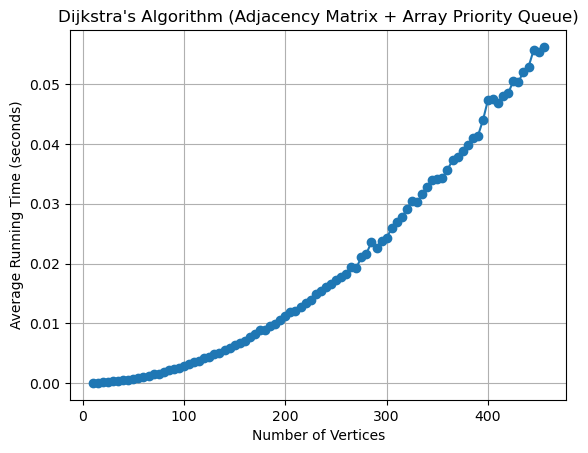

In [5]:
n_vertices = range(10, 460, 5)
n_repetitions = 10
running_times = []

for n in n_vertices:
    m = min(n * (n - 1), 3 * n)  # 3*n can be altered to increase density
    g1, g2 = make_graph(n, m)

    if g1 is None:
        running_times.append(None)
        continue

    start_time = time.time()
    for _ in range(n_repetitions):
        source = randint(0, n - 1)
        dijkstra_adj_matrix_array(g1, source)
    avg_time = (time.time() - start_time) / n_repetitions
    running_times.append(avg_time)

# -------------------------
# Plot Results
# -------------------------
plt.plot(n_vertices, running_times, 'o-')
plt.xlabel('Number of Vertices')
plt.ylabel('Average Running Time (seconds)')
plt.title('Dijkstra\'s Algorithm (Adjacency Matrix + Array Priority Queue)')
plt.grid(True)
plt.show()

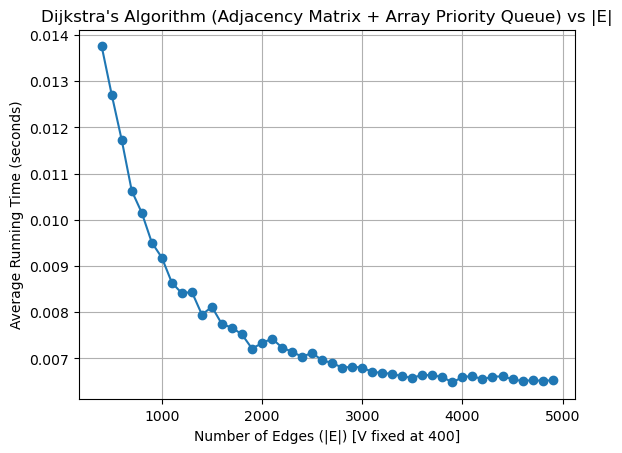

In [20]:
n = 200  # fixed number of vertices
max_edges = n * (n - 1)  # max edges for simple directed graph

# Start from minimum (n), grow by 20% each step
edge_list = []
e = n  # start with one edge per node on average
while e <= max_edges:
    edge_list.append(int(e))
    e *= 1.2  # grow by 20% each step
n_repetitions = 5  
running_times = []
edge_counts = []

for m in edge_steps:
    g1, g2 = make_graph(n, m)

    if g1 is None:
        running_times.append(None)
        edge_counts.append(m)
        continue

    start_time = time.time()
    for _ in range(n_repetitions):
        source = randint(0, n - 1)
        dijkstra_adj_matrix_array(g1, source)
    avg_time = (time.time() - start_time) / n_repetitions
    running_times.append(avg_time)
    edge_counts.append(m)

# -------------------------
# Plot Results
# -------------------------
plt.plot(edge_counts, running_times, 'o-')
plt.xlabel('Number of Edges (|E|) [V fixed at 400]')
plt.ylabel('Average Running Time (seconds)')
plt.title('Dijkstra\'s Algorithm (Adjacency Matrix + Array Priority Queue) vs |E|')
plt.grid(True)
plt.show()